In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00


In [3]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import networkx as nx

# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Print dataset statistics
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features per node: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433
Number of classes: 7


Done!


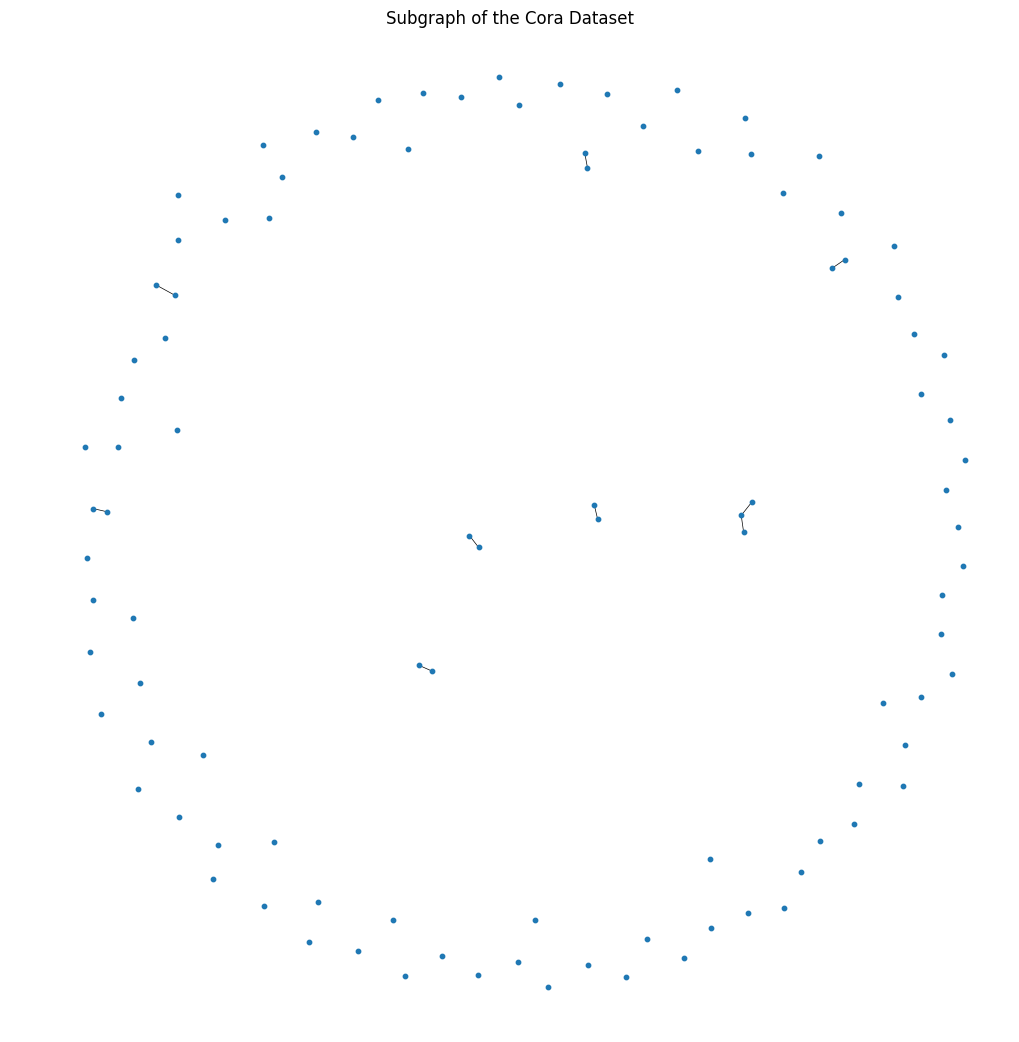

In [4]:
# Convert to networkx graph for visualization
g = nx.Graph()
g.add_edges_from(data.edge_index.t().tolist())

# Draw a small subgraph
subgraph_nodes = list(range(100))
subgraph = g.subgraph(subgraph_nodes)

plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=False, node_size=10, width=0.5)
plt.title('Subgraph of the Cora Dataset')
plt.show()

In [5]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def test(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

train_acc = test(data.train_mask)
val_acc = test(data.val_mask)
test_acc = test(data.test_mask)

print(f'\nGCN Model Performance:')
print(f'Train Accuracy: {train_acc:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 010, Loss: 0.7676
Epoch: 020, Loss: 0.1392
Epoch: 030, Loss: 0.0343
Epoch: 040, Loss: 0.0169
Epoch: 050, Loss: 0.0140
Epoch: 060, Loss: 0.0150
Epoch: 070, Loss: 0.0167
Epoch: 080, Loss: 0.0175
Epoch: 090, Loss: 0.0173
Epoch: 100, Loss: 0.0164
Epoch: 110, Loss: 0.0154
Epoch: 120, Loss: 0.0146
Epoch: 130, Loss: 0.0138
Epoch: 140, Loss: 0.0132
Epoch: 150, Loss: 0.0126
Epoch: 160, Loss: 0.0121
Epoch: 170, Loss: 0.0117
Epoch: 180, Loss: 0.0113
Epoch: 190, Loss: 0.0109
Epoch: 200, Loss: 0.0106

GCN Model Performance:
Train Accuracy: 1.0000
Validation Accuracy: 0.7760
Test Accuracy: 0.8070


Early stopping at epoch 167
Early stopping at epoch 40
Early stopping at epoch 56
Early stopping at epoch 29
Early stopping at epoch 23
Early stopping at epoch 31
    hidden_units  learning_rate  dropout  best_val_acc
0             16          0.010      0.0         0.776
1             16          0.010      0.5         0.794
2             16          0.001      0.0         0.744
3             16          0.001      0.5         0.766
4             32          0.010      0.0         0.800
5             32          0.010      0.5         0.780
6             32          0.001      0.0         0.782
7             32          0.001      0.5         0.780
8             64          0.010      0.0         0.784
9             64          0.010      0.5         0.802
10            64          0.001      0.0         0.784
11            64          0.001      0.5         0.788


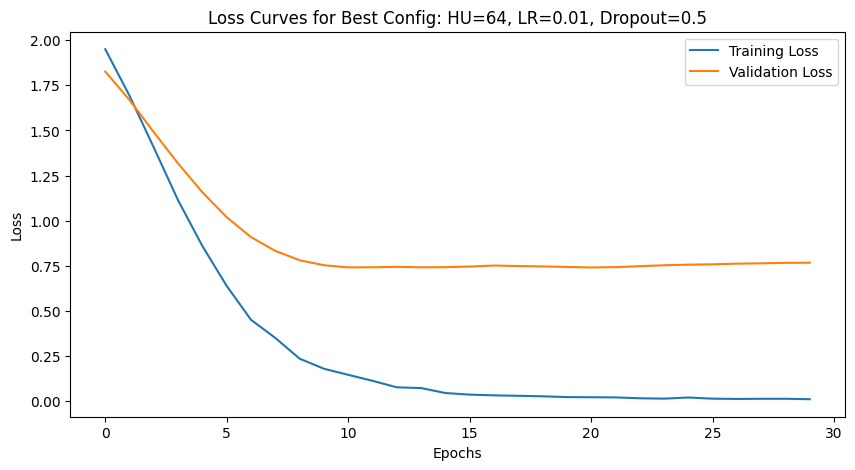

In [10]:
import pandas as pd

hidden_units_list = [16, 32, 64]
learning_rate_list = [0.01, 0.001]
dropout_list = [0.0, 0.5]

results = []

class GCNWithDropout(torch.nn.Module):
    def __init__(self, hidden_channels, dropout_rate):
        super(GCNWithDropout, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x

for hidden_units in hidden_units_list:
    for lr in learning_rate_list:
        for dropout in dropout_list:
            model = GCNWithDropout(hidden_channels=hidden_units, dropout_rate=dropout)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)

            train_losses = []
            val_losses = []
            val_accuracies = []
            patience = 10 # Number of epochs to wait after last improvement
            min_val_loss = float('inf')
            epochs_no_improve = 0

            for epoch in range(1, 201):
                train_loss = train()
                model.eval()
                out = model(data.x, data.edge_index)
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    epochs_no_improve = 0
                    # Optionally save the best model
                    # torch.save(model.state_dict(), 'best_model.pth')
                else:
                    epochs_no_improve += 1

                if epochs_no_improve == patience:
                    print(f'Early stopping at epoch {epoch}')
                    break
                val_acc = test(data.val_mask)

                train_losses.append(train_loss.item())
                val_losses.append(val_loss.item())
                val_accuracies.append(val_acc)

            results.append({
                'hidden_units': hidden_units,
                'learning_rate': lr,
                'dropout': dropout,
                'best_val_acc': max(val_accuracies),
                'train_losses': train_losses,
                'val_losses': val_losses
            })

results_df = pd.DataFrame(results)
print(results_df[['hidden_units', 'learning_rate', 'dropout', 'best_val_acc']])

# Plot training and validation loss for the best configuration
best_config = results_df.loc[results_df['best_val_acc'].idxmax()]
plt.figure(figsize=(10, 5))
plt.plot(best_config['train_losses'], label='Training Loss')
plt.plot(best_config['val_losses'], label='Validation Loss')
plt.title(f"Loss Curves for Best Config: HU={best_config['hidden_units']}, LR={best_config['learning_rate']}, Dropout={best_config['dropout']}")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
import torch
import torch.nn.functional as F
from torch.nn import Module, Linear, BatchNorm1d
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv, SAGEConv, GINConv

# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Common training and testing functions
def train_model(model, optimizer, criterion):
    """Generic function to train any of the models."""
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test_model(model):
    """Generic function to test any of the models."""
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    accs = {}
    for mask_name, mask in data('train_mask', 'val_mask', 'test_mask'):
        correct = pred[mask] == data.y[mask]
        accs[mask_name] = int(correct.sum()) / int(mask.sum())
    return accs

In [12]:
class GAT(Module):
    def __init__(self, hidden_channels, heads):
        super(GAT, self).__init__()
        # First GAT layer with 8 attention heads
        self.conv1 = GATConv(dataset.num_node_features, hidden_channels, heads=heads, dropout=0.3)
        # Second GAT layer. Input features are heads * hidden_channels, output is number of classes.
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads=1, concat=False, dropout=0.3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x) # ELU is a common activation for GAT
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# --- GAT Training and Evaluation ---
print("--- Training GAT Model ---")
gat_model = GAT(hidden_channels=8, heads=8).to(device)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()



for epoch in range(1, 201):
    loss = train_model(gat_model, gat_optimizer, criterion)
    if epoch % 20 == 0:
        accs = test_model(gat_model)
        print(f'GAT Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {accs["val_mask"]:.4f}')

gat_final_accs = test_model(gat_model)
print(f'\nFinal GAT Performance:')
print(f'GAT Train Accuracy: {gat_final_accs["train_mask"]:.4f}')
print(f'GAT Validation Accuracy: {gat_final_accs["val_mask"]:.4f}')
print(f'GAT Test Accuracy: {gat_final_accs["test_mask"]:.4f}')
print("-" * 25)

--- Training GAT Model ---
GAT Epoch: 020, Loss: 0.1111, Val Acc: 0.7500
GAT Epoch: 040, Loss: 0.1143, Val Acc: 0.7300
GAT Epoch: 060, Loss: 0.0440, Val Acc: 0.7500
GAT Epoch: 080, Loss: 0.0273, Val Acc: 0.7600
GAT Epoch: 100, Loss: 0.0743, Val Acc: 0.7760
GAT Epoch: 120, Loss: 0.0810, Val Acc: 0.7700
GAT Epoch: 140, Loss: 0.1249, Val Acc: 0.7600
GAT Epoch: 160, Loss: 0.0588, Val Acc: 0.7440
GAT Epoch: 180, Loss: 0.0657, Val Acc: 0.7580
GAT Epoch: 200, Loss: 0.0587, Val Acc: 0.7580

Final GAT Performance:
GAT Train Accuracy: 1.0000
GAT Validation Accuracy: 0.7580
GAT Test Accuracy: 0.7920
-------------------------


In [13]:
class GraphSAGE(Module):
    def __init__(self, hidden_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, hidden_channels, aggr='mean')
        self.conv2 = SAGEConv(hidden_channels, dataset.num_classes, aggr='mean')

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# --- GraphSAGE Training and Evaluation ---
print("\n--- Training GraphSAGE Model ---")
sage_model = GraphSAGE(hidden_channels=64).to(device)
sage_optimizer = torch.optim.Adam(sage_model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train_model(sage_model, sage_optimizer, criterion)
    if epoch % 20 == 0:
        accs = test_model(sage_model)
        print(f'SAGE Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Acc: {accs["val_mask"]:.4f}')

sage_final_accs = test_model(sage_model)
print(f'\nFinal GraphSAGE Performance:')
print(f'SAGE Train Accuracy: {sage_final_accs["train_mask"]:.4f}')
print(f'SAGE Validation Accuracy: {sage_final_accs["val_mask"]:.4f}')
print(f'SAGE Test Accuracy: {sage_final_accs["test_mask"]:.4f}')
print("-" * 25)


--- Training GraphSAGE Model ---
SAGE Epoch: 020, Loss: 0.0012, Val Acc: 0.7640
SAGE Epoch: 040, Loss: 0.0060, Val Acc: 0.7640
SAGE Epoch: 060, Loss: 0.0035, Val Acc: 0.7740
SAGE Epoch: 080, Loss: 0.0068, Val Acc: 0.7600
SAGE Epoch: 100, Loss: 0.0055, Val Acc: 0.7720
SAGE Epoch: 120, Loss: 0.0043, Val Acc: 0.7720
SAGE Epoch: 140, Loss: 0.0045, Val Acc: 0.7720
SAGE Epoch: 160, Loss: 0.0033, Val Acc: 0.7740
SAGE Epoch: 180, Loss: 0.0049, Val Acc: 0.7700
SAGE Epoch: 200, Loss: 0.0036, Val Acc: 0.7720

Final GraphSAGE Performance:
SAGE Train Accuracy: 1.0000
SAGE Validation Accuracy: 0.7720
SAGE Test Accuracy: 0.8030
-------------------------
